In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
import pandas as pd
from astropy.io import ascii
import scipy.stats as stats
from ipywidgets import FloatProgress
from IPython.display import display

import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

In [2]:
def drawHeatMap(dataArray, imageSize, x, y, nData=[], colorBarLabel="", textOn=True, forceInt=True):
    dx = x[(1,0)] - x[(0,0)]
    dy = y[(0,1)] - y[(0,0)]
    extent = [x[(0,0)], x[(-1,0)]+dx,y[(0,0)],y[(0,-1)]+dy]
    plt.figure(figsize=imageSize)
    # fig, ax = plt.subplots(figsize=imageSize);
    ax = plt.gca()

    da = np.transpose(dataArray)
    # im = ax.imshow(da, extent = extent, origin='lower')
    im = ax.imshow(da, extent = extent, origin='lower', cmap="Greys")
    ax.set_aspect(10)
    
    if len(nData) == 0:
        nData = np.ones(dataArray.shape)

    # ax.imshow(da, origin='lower')
    arrayShape = da.shape
    minda = np.min(da)
    maxda = np.max(da)
    daRange = maxda - minda
    for i in range(arrayShape[0]):
        for j in range(arrayShape[1]):
            if da[i, j] > minda + daRange*0.5:
                # cstr = "k"
                cstr = "w"
            else:
                # cstr = "w"
                cstr = "k"
            if np.abs(da[i,j]) < 100:
                fsz = 9
            else:
                fsz = 6
            
            if textOn:
                if nData[(j,i)] > 0:
                    if forceInt:
                        ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, da[i, j].astype("int"),
                               ha="center", va="center", color=cstr, fontsize=fsz)
                    else:
                        ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, da[i, j],
                               ha="center", va="center", color=cstr, fontsize=fsz)                        
                else:
                    ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, "-",
                           ha="center", va="center", color=cstr, fontsize=fsz)

            
    
    ax.tick_params(axis = "both", labelsize = 12)
    im_ratio = float(da.shape[0])/da.shape[1] 
    cbh = plt.colorbar(im,fraction=0.0477*im_ratio, pad=0.02)
    cbh.ax.set_ylabel(colorBarLabel, fontSize = 16)

    # ax.invert_yaxis()

In this notebook we measure DR25 vetting completeness, defined as the fraction of detections (TCEs) that are correctly vetted as planet candidates.  We use the set of injected on-target planets that were detected at the correct ephemeris as the base set of TCEs.  All of these TCEs are "true planets" by definition.  Then vetting completeness is the fraction of these TCEs that are vetter as PC by the robovetter.  We study how vetting completeness depends on period and MES.

We think of TCEs as consisting of two sets: those that are dispositioned as FP and those that are dispositioned as PC.  Then we can think of the vetting process as drawing from the set of TCEs, with a probability $r$ of selecting PCs. We identify $r$ with vetting completeness.  Then the probability distribution of selecting $c$ FPs from $n$ TCEs is given by the binomial distribution

$$P\{c\} = \left( \begin{array}{c} n \\ c \end{array} \right) r^c (1-r)^{n-c}.$$

In this spirit, we define the vetting effectiveness $r$ as the probability of drawing PCs from inverted/scrambled TCEs, found via the Bayesian inference $p(r|n, c) \propto p(c|r, n) p(r)$, where $c$ is the number of TCEs vetted as PCs, $n$ is the total number of TCEs,
$$p(c|r, n) = \left( \begin{array}{c} n \\ c \end{array} \right) r^c (1-r)^{n-c}$$ and
$p(r)$ is a prior distribution of the probability $r$.  By putting the data on a grid indexed by $i,j$, we can fit effectiveness as a function parameterized by a vector $\theta$, $r(\theta,\mathrm{period},\mathrm{MES})$, as $p(\theta)|n_{i,j}, c_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) \propto p(c_{i,j}|\theta, n_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) p(\theta)$, where $p(\theta)$ is some prior distribution of the parameters.


First we define our stellar and planet populations.

In [3]:
stellarType = "GKM"

scoreCut = 0.0;

scenario = "large"
if scenario == "small":
    # small planet long period scenario
    periodMin = 200;
    periodMax = 400;
    rpMin = 0.75;
    rpMax = 2.5;
    mesMin = 0;
    mesMax = 30;
elif scenario == "large":
    # all planet scenario
    periodMin = 0;
    periodMax = 600;
    rpMin = 0.5;
    rpMax = 15;
    mesMin = 0;
    mesMax = 30;
else:
    raise ValueError('Bad scenario name');

Then we define our binomial probability distribution function.

In [4]:
def binPdf(n, r, c):
    return sp.comb(n,c)*(r**c)*((1-r)**(n-c));

Then we define a bunch of models of the rate as functions of period ($x$) and MES ($y$) which are identified by the variable 'model'.

Read in our data.

In [5]:
dataLoc = "../data/"
injTceList = dataLoc + "kplr_dr25_inj1_tces.txt"
tcelist = dataLoc + "DR25-Injected-Recovered-OnTarget-Planet-TCEs-1-1-Prat.txt"
# starlist = dataLoc + "dr25_stellar_updated_feh_" + stellarType + ".txt"
starlist = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_notimeout_" + stellarType + ".txt"

In [6]:
# Load the stellar population we want to use
kic = pd.read_csv(starlist)
# Load D2 table
injTces = ascii.read(injTceList)
tces = np.genfromtxt(tcelist, dtype='str')

tceKepids = np.zeros(len(tces));
for i in range(len(tces)):
    s = tces[i].split('-');
    tceKepids[i] = int(s[0]);
print(tceKepids)

print("num injected/recovered TCEs: " + str(np.size(tceKepids)))
print("num injected TCEs: " + str(np.size(injTces)))

[  757280.   891916.   892195. ... 12984183. 12984200. 12984214.]
num injected/recovered TCEs: 46463
num injected TCEs: 45377


In [7]:
injTces = injTces[np.in1d(injTces['TCE_ID'],tces)]
print("num injected TCEs after trimming to injected/recovered: " + str(np.size(injTces)))

num injected TCEs after trimming to injected/recovered: 44794


In [8]:
# Select only those TCEs that are in this stellar population
injTces = injTces[np.in1d(injTces['KIC'],kic.kepid)]
print("after: " + str(np.size(injTces)))

after: 16653


In [9]:
# Do some basic stats
print(injTceList)
print("# of injected TCEs: " + str(len(injTces)))
print("# of injected PCs: " + str(len(injTces[injTces['Disp']=='PC'])))
print("# of injected FPs: " + str(len(injTces[injTces['Disp']=='FP'])))
print(' ')

print("for " + str(rpMax) + " < Rp < " + str(rpMax) + ", " + str(periodMin) + " < period < " + str(periodMax) + ":");
print("# of injected injected TCEs: " + str(len(injTces[np.all([                   \
    injTces['Rp']>rpMin,injTces['Rp']<rpMax,injTces['period']>periodMin,injTces['period']<periodMax], axis=0)])))
print("# of injected PCs: " + str(len(injTces[np.all([injTces['Disp']=='PC',\
    injTces['Rp']>rpMin,injTces['Rp']<rpMax,injTces['period']>periodMin,injTces['period']<periodMax], axis=0)])))
print("# of injected FPs: " + str(len(injTces[np.all([injTces['Disp']=='FP',\
    injTces['Rp']>rpMin,injTces['Rp']<rpMax,injTces['period']>periodMin,injTces['period']<periodMax], axis=0)])))

../data/kplr_dr25_inj1_tces.txt
# of injected TCEs: 16653
# of injected PCs: 14596
# of injected FPs: 2057
 
for 15 < Rp < 15, 0 < period < 600:
# of injected injected TCEs: 16620
# of injected PCs: 14564
# of injected FPs: 2056


Separate out the PCs and FPs

In [10]:
pcIndex = np.where(injTces[injTces['Disp']=='PC'])
fpIndex = np.where(injTces[injTces['Disp']=='FP'])
pcs = injTces[pcIndex]
fps = injTces[fpIndex]

Select the TCEs that are in our desired population and plot them.

In [11]:
spIndex = np.where(np.all([
    injTces['Rp']>rpMin,injTces['Rp']<rpMax,injTces['period']>periodMin,injTces['period']<periodMax], axis=0))
spInjTces = injTces[spIndex]
spInjPcs = spInjTces[(spInjTces['Disp']=='PC') & (spInjTces['Score']>=scoreCut)]
spInjFps = spInjTces[(spInjTces['Disp']=='FP') | (spInjTces['Score']<scoreCut)]

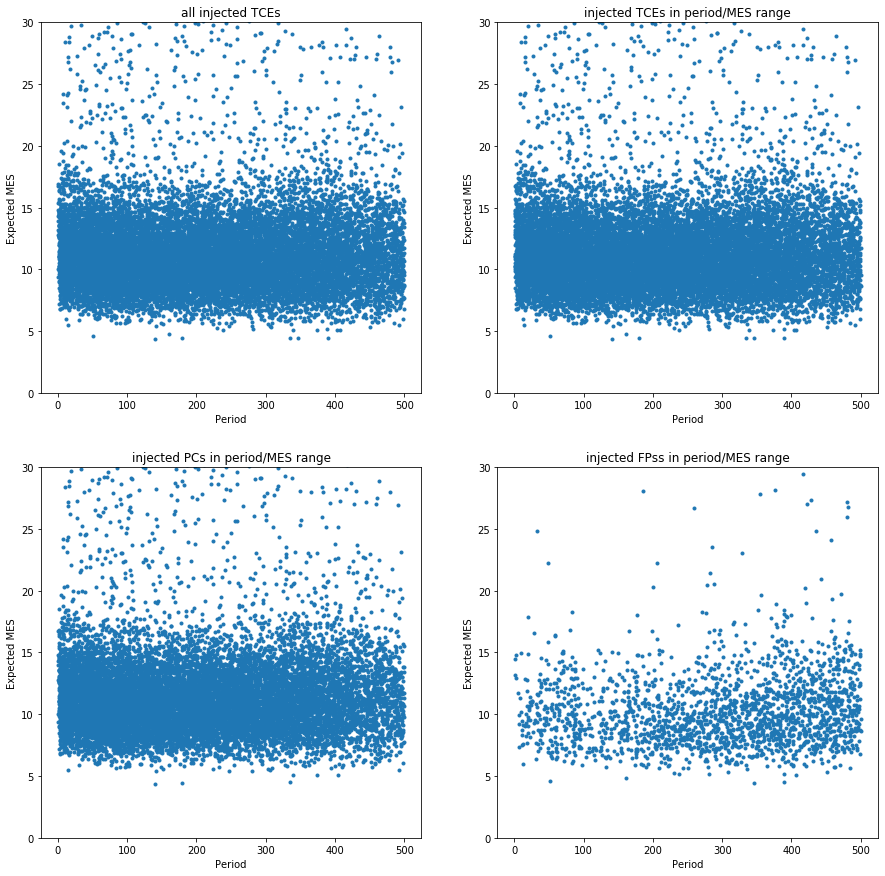

In [12]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.scatter(injTces['period'], injTces['Expected_MES'], marker=".")
plt.ylim(0, mesMax)
plt.title("all injected TCEs")
plt.ylabel('Expected MES')
plt.xlabel('Period')

plt.subplot(2,2,2)
plt.scatter(spInjTces['period'], spInjTces['Expected_MES'], marker=".")
plt.ylim(0, mesMax)
plt.title("injected TCEs in period/MES range")
plt.xlabel('Period')
plt.ylabel('Expected MES')

plt.subplot(2,2,3)
plt.scatter(spInjPcs['period'], spInjPcs['Expected_MES'], marker=".")
plt.ylim(0, mesMax)
plt.title("injected PCs in period/MES range")
plt.ylabel('Expected MES')
plt.xlabel('Period')

plt.subplot(2,2,4)
plt.scatter(spInjFps['period'], spInjFps['Expected_MES'], marker=".")
plt.ylim(0, mesMax)
plt.title("injected FPss in period/MES range")
plt.ylabel('Expected MES')
plt.xlabel('Period')
plt.show()

Bin the populations onto a grid.  The binned TCEs and PCs are the input to our MCMC analysis.

In [13]:
dPeriod = 10
dMes = 1

p0 = periodMin
pEnd = periodMax
m0 = mesMin
mEnd = mesMax

# make the period-mes grid
NPeriod = int((pEnd - p0)/dPeriod)
NMes = int((mEnd - m0)/dMes)
tceGrid = np.zeros((NPeriod,NMes))
cellPeriod = np.zeros((NPeriod,NMes))
cellMes = np.zeros((NPeriod,NMes))
pcGrid = np.zeros((NPeriod,NMes))
fpGrid = np.zeros((NPeriod,NMes))

# count how many points are in each cell
for p in range(NPeriod):
    for m in range(NMes):
        cellPeriod[(p,m)] = p0 + p*dPeriod
        cellMes[(p,m)] = m0 + m*dMes
        pointsInCell = np.where(
            (spInjTces['period'] > cellPeriod[(p,m)]) 
            & (spInjTces['period'] <= cellPeriod[(p,m)]+dPeriod) 
            & (spInjTces['Expected_MES'] > cellMes[(p,m)]) 
            & (spInjTces['Expected_MES'] <= cellMes[(p,m)]+dMes))
        tceGrid[(p,m)] = len(pointsInCell[0])

        pointsInCell = np.where(
            (spInjPcs['period'] > cellPeriod[(p,m)]) 
            & (spInjPcs['period'] <= cellPeriod[(p,m)]+dPeriod) 
            & (spInjPcs['Expected_MES'] > cellMes[(p,m)]) 
            & (spInjPcs['Expected_MES'] <= cellMes[(p,m)]+dMes))
        pcGrid[(p,m)] = len(pointsInCell[0])


        pointsInCell = np.where(
            (spInjFps['period'] > cellPeriod[(p,m)]) 
            & (spInjFps['period'] <= cellPeriod[(p,m)]+dPeriod) 
            & (spInjFps['Expected_MES'] > cellMes[(p,m)]) 
            & (spInjFps['Expected_MES'] <= cellMes[(p,m)]+dMes))
        fpGrid[(p,m)] = len(pointsInCell[0])

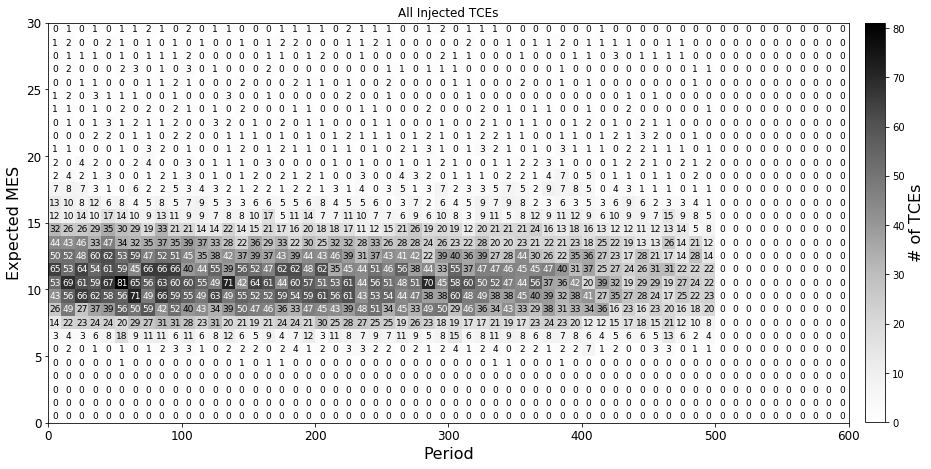

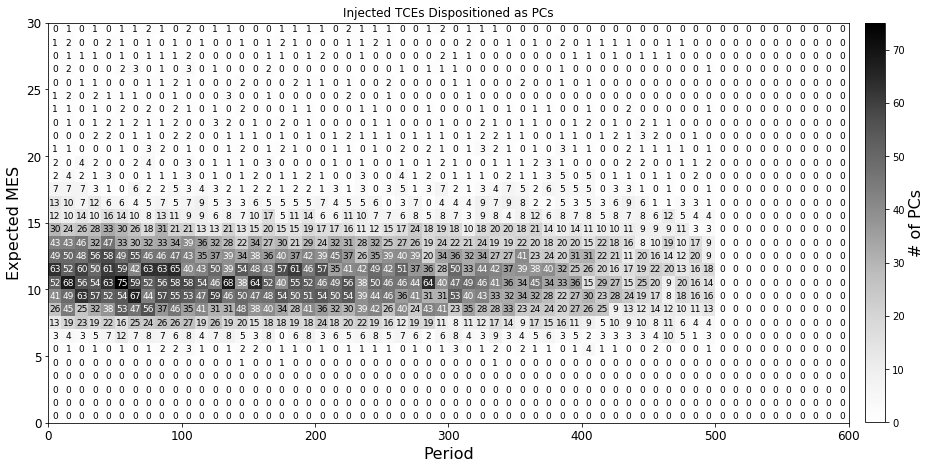

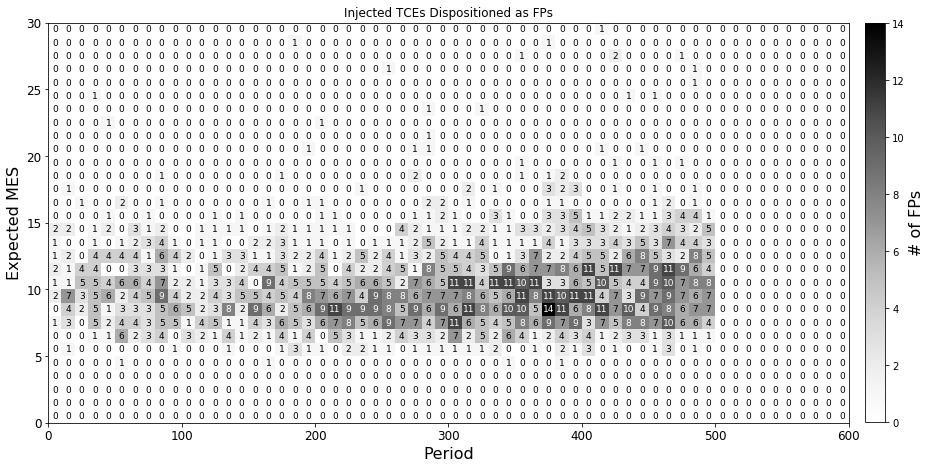

In [14]:
drawHeatMap(tceGrid, (15,15), cellPeriod, cellMes, colorBarLabel="# of TCEs")
plt.ylabel('Expected MES', fontsize = 16)
plt.xlabel('Period', fontsize = 16)
#plt.savefig("vetCompNTCEs.pdf",bbox_inches='tight')
plt.title("All Injected TCEs")

drawHeatMap(pcGrid, (15,15), cellPeriod, cellMes, colorBarLabel="# of PCs")
plt.title("Injected TCEs Dispositioned as PCs")
plt.ylabel('Expected MES', fontsize = 16)
plt.xlabel('Period', fontsize = 16)
drawHeatMap(fpGrid, (15,15), cellPeriod, cellMes, colorBarLabel="# of FPs")
plt.title("Injected TCEs Dispositioned as FPs")
plt.ylabel('Expected MES', fontsize = 16)
plt.xlabel('Period', fontsize = 16)

plt.show()

Compute the PC fraction in each cell.  This is not used in our analysis, but is a qualitative guide suggesting what functions may be the best fit.

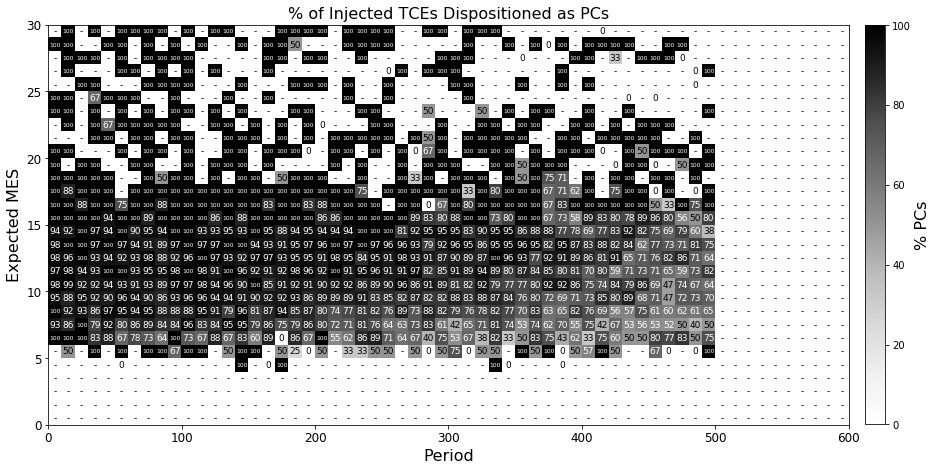

gridShape = (60, 30), dx = 0.016666666666666666, dy = 0.03333333333333333


In [15]:
pcFrac = np.zeros(np.shape(tceGrid))
minTcePerCell = 0
pcFrac[tceGrid>minTcePerCell] = pcGrid[tceGrid>minTcePerCell]/tceGrid[tceGrid>minTcePerCell]
drawHeatMap(np.round(100*pcFrac), (15,15), cellPeriod, cellMes, colorBarLabel="% PCs", nData = tceGrid)
plt.ylabel('Expected MES', fontsize = 16)
plt.xlabel('Period', fontsize = 16)
#plt.savefig("vetCompInjRate.pdf",bbox_inches='tight')
plt.title("% of Injected TCEs Dispositioned as PCs", fontsize = 16)
plt.show()

pcFlat = pcGrid.flatten()
tceFlat = tceGrid.flatten()
# cellX = cellPeriod.flatten()
# cellY = cellMes.flatten()

# convert to homogeneous coordinates on unit square [0,1]
cellX, cellY = funcModels.normalizeRange(cellPeriod, cellMes, [periodMin, periodMax], [mesMin, mesMax])
gridShape = np.shape(cellX)
dx = 1./gridShape[0]
dy = 1./gridShape[1]
print("gridShape = " + str(gridShape) + ", dx = " + str(dx) + ", dy = " + str(dy))

cellXFlat = cellX.flatten()
cellYFlat = cellY.flatten()

pcFlat[tceFlat<minTcePerCell] = 0
tceFlat[tceFlat<minTcePerCell] = 0

tceData = [cellXFlat, cellYFlat, tceFlat, pcFlat]

We're ready to compute a Bayesian inference of the success probability $r$:

$$p(r|c, n) \propto p(c|r, n) p(r).$$

But we're computing $r$ as a function of period $p$, MES $m$, and parameters $\theta$, $r(\theta, p, m)$. So our inference becomes 

$$p(\theta|c, n, p, m) \propto p(c|\theta, n, p, m) p(\theta).$$

Because each cell is independent, we linearize the array to a list of cells indexed by $k$.  Then the likelihood for each cell is

$$p(c_k|\theta, n_k, p_k, m_k) = \left( \begin{array}{c_k} n_k \\ c_k \end{array} \right) r(\theta, p_k , m_k )^{c_k} (1-r(\theta, p_k , m_k ))^{n_k-c_k}$$

Because the $N$ cells are independent, the likelihood for the collection of cells is

$$p(c|\theta, n, p, m) \equiv p(c_1, \ldots, c_N|\theta, n_1, \ldots, n_N, p_1, \ldots, p_N, m_1, \ldots, m_N) = \prod_k \left( \begin{array}{c_k} n_k \\ c_k \end{array} \right) r(\theta, p_k , m_k )^{c_k} (1-r(\theta, p_k , m_k ))^{n_k-c_k}.$$

The log-likelihood is then

$$\log p(c|\theta, n, p, m) = \sum_k \log \left(\left( \begin{array}{c_k} n_k \\ c_k \end{array} \right) r(\theta, p_k , m_k )^{c_k} (1-r(\theta, p_k , m_k ))^{n_k-c_k} \right)$$ 
$$= \sum_k \left[ \log \left(\begin{array}{c_k} n_k \\ c_k \end{array} \right) + c_k \log \left(r(\theta, p_k , m_k ) \right) + \left( n_k-c_k \right) \log(1-r(\theta, p_k , m_k )) \right] $$
 

We code this as

In [16]:
def lnBinlike(theta, data, model):
    x, y, n, c = data
    r = funcModels.rateModel(x,y,theta,model)
    clnr = c*np.log(r)
    clnr[c==0] = 0
    lpl = np.sum(np.log(spec.comb(n,c)) + clnr + (n-c)*np.log(1-r))
    # some diagnostics for when things go wrong
    if np.isnan(lpl):
        return -np.inf
    else:
        return lpl

For our prior $p(r)$, we'll set the prior = 1 on the interval $[0, 1]$ and zero otherwise.

In [17]:
def lnBinprior(theta, data, model):
    x, y, n, c = data
    # print(theta)
    if model == "linearX":
        if -5000.0 < theta[0] < 5000.0 and 0.0 < theta[1] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "linearXY":
        if -5000.0 < theta[0] < 5000.0 and -5000.0 < theta[1] < 5000.0 \
        and 0.0 < theta[2] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "gaussian":
        if -10.0 < theta[0] < 10.0 and -10.0 < theta[1] < 10.0 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 and -1 <= theta[4] <= 1 and 0 <= theta[5] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX":
        if -10.0 < theta[0] < 10.0 \
        and 1e-4 < theta[1] < 1e4 and 0 < theta[2] < 1e6 and 0 < theta[3] < 1e6 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX0":
        if 0 <= theta[0] <= 1000 \
        and 1e-4 < theta[1] < 1e4 and 0 < theta[2] < 1e6 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticY0":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 1e4 and 0 < theta[2] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX0xlogisticY0":
        if -1 <= theta[0] <= 2 and -1 <= theta[1] <= 2 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 \
        and 0 < theta[4] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX0xlogisticY02":
        if -1 <= theta[0] <= 2 and -1 <= theta[1] <= 2 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 \
        and 0.01 < theta[4] < 10 and 0.01 < theta[5] < 10 \
        and 0 < theta[6] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX0xRotatedLogisticY0":
        if -1 <= theta[0] <= 2 and -1 <= theta[1] <= 2 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 \
        and -180 < theta[4] < 180 \
        and 0 < theta[5] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX0xRotatedLogisticY02":
        if -1 <= theta[0] <= 2 and -1 <= theta[1] <= 2 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 \
        and 0.01 < theta[4] < 10 \
        and -180 < theta[5] < 180 \
        and 0 < theta[6] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX0xlogisticY0":
        if -1 <= theta[0] <= 2 and -1 <= theta[1] <= 2 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 \
        and -3 < theta[4] < 3 and -180 < theta[5] < 180 \
        and 0 < theta[6] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX0xlogisticY02":
        if -1 <= theta[0] <= 2 and -1 <= theta[1] <= 2 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 \
        and 0.01 < theta[4] < 10 and 0.01 < theta[5] < 10 \
        and -180 < theta[6] < 180 and -180 < theta[7] < 180 \
        and 0 < theta[8] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX0":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and 0 < theta[2] <= 1  and -180 < theta[3] < 180 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "dualBrokenPowerLaw":
        # print(funcModels.rateModel(x, y, theta, model))
        if 0 <= theta[0] <= 1 and 0 <= theta[1] <= 1 \
        and -2 < theta[2] < 0 and -2 < theta[3] < 0 and 0 < theta[4] < 1e4 and 0 < theta[5] < 1e4 \
        and 0 < theta[6] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf

Then the log posterior probability is $\log p(\theta|c, n, p, m) = \log p(c|\theta, n, p, m) + \log p(\theta)$, which we code as 

In [18]:
def lnBinprob(theta, data, model):
    lp = lnBinprior(theta, data, model)
    # print("lnPoisprior = " + str(lp))
    if not np.isfinite(lp):
        return -np.inf
    # print(str(lnPoislike(theta, A, c)))
    return lp + lnBinlike(theta, data, model)

We now perform the MCMC calculation of the log posterior.  We use a manual three-part strategy to find the best seed point: first we use the initial values in the model definitions.  This MCMC result is used to seed the second iterations, whose result is used to seed the third and final iteration.  We then initialize the MCMC walkers with a small Gaussian distribution around these starting points.

In [19]:
model = "logisticX0xRotatedLogisticY02"

if model == "logisticY0":
    initialPos = [ 0.14828331, 17.33408434,  0.92967224];
elif model == "logisticX0xlogisticY0":
    initialPos = [ 0.99560747,  0.14886312,  4.89150268, 22.22093359,  0.94770438];
elif model == "logisticX0xlogisticY02":
    initialPos = [ 0.81952689,  0.23524868,  4.7697679,  19.05683796,  2.05838984,  4.60039486, 0.99113786];
elif model == "rotatedLogisticX0xlogisticY0":
    initialPos = [ 1.08006382,  0.14448152,  4.07613918, 15.42298136,  0.75826285,  7.55065579,  0.98498245];
elif model == "logisticX0xRotatedLogisticY0":
    initialPos = [  1.01211435,   0.14979708,   5.4723763,   13.37211524, 0,   0.98427409]
elif model == "logisticX0xRotatedLogisticY02":
    initialPos = [  1.01211435,   0.14979708,   5.4723763,   13.37211524, 5, 0,   0.98427409]
elif model == "rotatedLogisticX0xlogisticY02":
    initialPos = [ 1.21729902,  0.25877038,  5.03162786, 21.4166877,   0.51381796,  4.01130569,  3.30628676,  6.15551683,  0.97623034];
elif model == "dualBrokenPowerLaw":
    initialPos = [ 0.44265552,  0.3179024,  -0.10705209, -0.98008117,  2.72776688,  0.06786803, 0.92982262];
else:
    initialPos = funcModels.initRateModel(model);

print(initialPos)

[1.01211435, 0.14979708, 5.4723763, 13.37211524, 5, 0, 0.98427409]


In [20]:
import scipy.optimize as op
nll = lambda *args: -lnBinlike(*args)
result = op.minimize(nll, initialPos, args=(tceData, model))
maxLikelihoodResult = result["x"]
modelLabels = funcModels.getModelLabels(model)
for i in range(0,len(maxLikelihoodResult)):
    print("maximum Likelihood " + modelLabels[i] + ":={:.3f}".format(maxLikelihoodResult[i]))
    
if lnBinprior(maxLikelihoodResult, tceData, model) == -np.inf:
    maxLikelihoodResult = initialPos;
    print("violates prior, replacing maxLikelihoodResult result with initialPos")

x, y, n, c = tceData
r = funcModels.rateModel(x,y,maxLikelihoodResult,model)
print("maximum Likelihood rate min = {:.3f}".format(np.min(np.min(r))) + ", max = {:.3f}".format(np.max(np.max(r))))

maximum Likelihood $x_0$:=1.014
maximum Likelihood $y_0$:=0.264
maximum Likelihood $k_x$:=5.440
maximum Likelihood $k_y$:=20.536
maximum Likelihood $\nu$:=4.284
maximum Likelihood $\phi$:=7.098
maximum Likelihood $A$:=0.973
maximum Likelihood rate min = 0.113, max = 0.970


In [21]:
import emcee

# we'll use 20 walkers and 2000 steps so this doesn't take too long
# 100 walkers and 5000 steps is better

ndim, nwalkers = len(maxLikelihoodResult), 20
pos = [maxLikelihoodResult + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnBinprob, args=(tceData, model))
 
sampler.run_mcmc(pos, 2000)

samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
modelLabels = funcModels.getModelLabels(model)
dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84], axis=0)))
dataResult = list(dataResult)
for i in range(0,ndim):
    v = dataResult[i];    
    print("MCMC " + modelLabels[i] + ":={:.3f}".format(v[0]) + "+{:.3f}".format(v[1]) + "-{:.3f}".format(v[2]))
    # print("true " + modelLabels[i] + ":={:.3f}".format(trueTheta[i]))

resultSize = np.shape(dataResult)
fitTheta = np.zeros(resultSize[0])
for i in range(resultSize[0]):
    fitTheta[i] = dataResult[i][0]
print("pcFitTheta:")
print(fitTheta)

# print("compared to: rate={:.3f}".format(rate))

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


MCMC $x_0$:=1.011+0.041-0.031
MCMC $y_0$:=0.281+0.026-0.051
MCMC $k_x$:=5.549+0.638-0.643
MCMC $k_y$:=21.796+4.035-4.114
MCMC $\nu$:=5.481+2.619-2.794
MCMC $\phi$:=7.477+1.265-1.146
MCMC $A$:=0.972+0.006-0.006
pcFitTheta:
[ 1.01099938  0.2812184   5.54855826 21.79649826  5.48138402  7.4765544
  0.97218195]


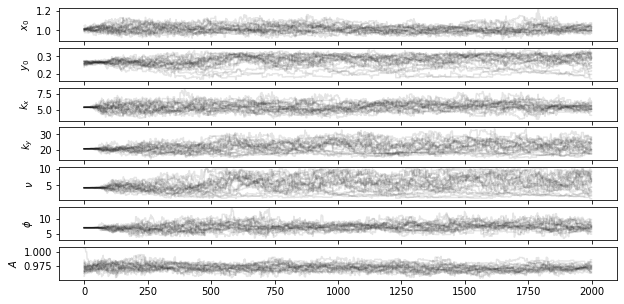

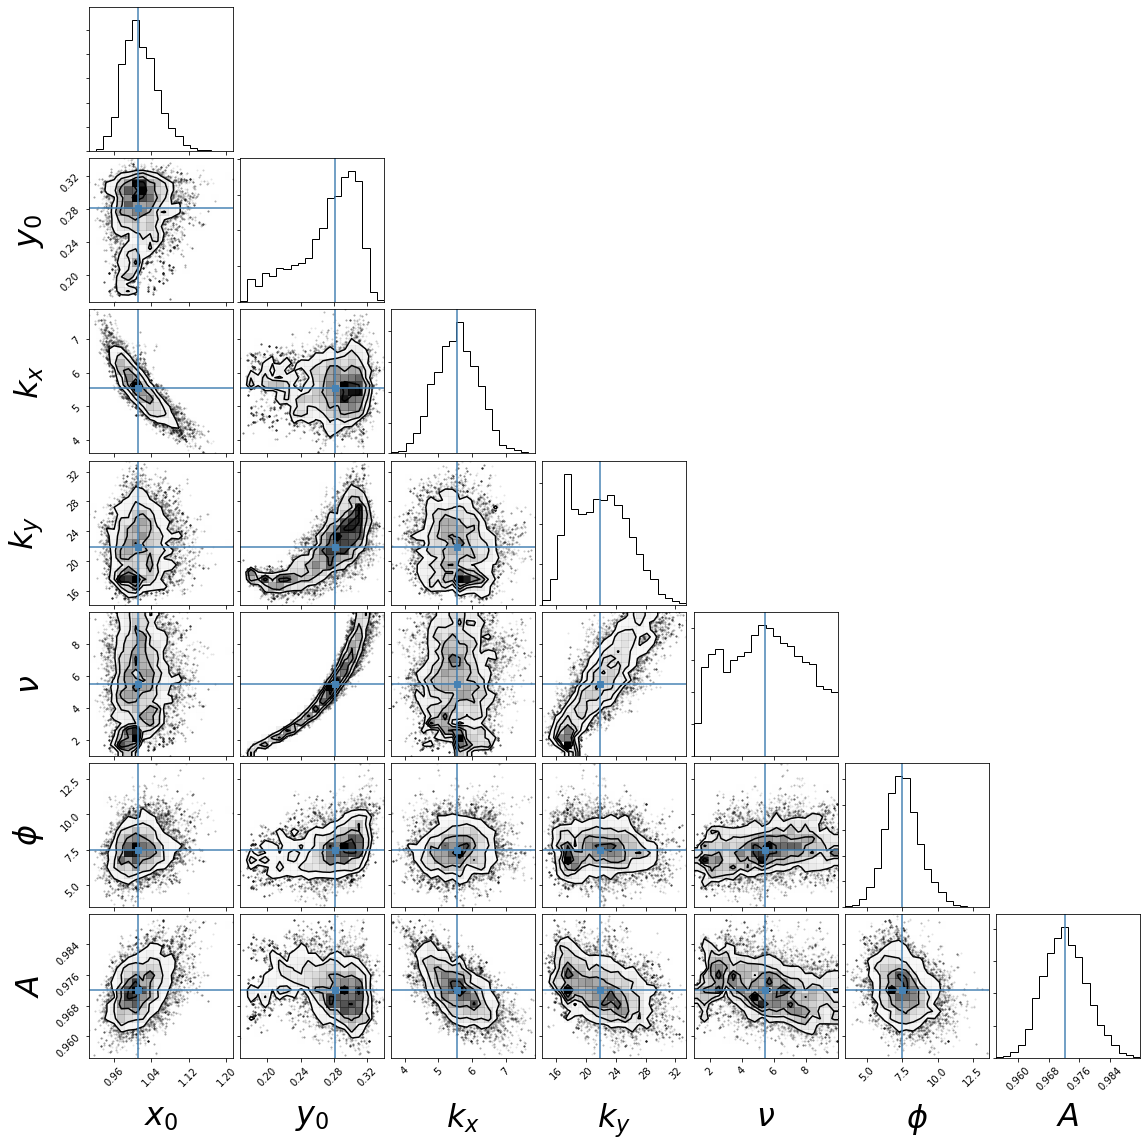

In [22]:
import importlib
importlib.reload(funcModels)
plt.figure(figsize=(10,5))
for i in range(0,ndim):
    plt.subplot(ndim,1,i+1)
    plt.plot(np.transpose(sampler.chain[:, :, i]), color="k", alpha=0.1)
    plt.ylabel(modelLabels[i])
    
import corner
modelLabels = funcModels.getModelLabels(model)
# fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
#                       truths=[m_true, b_true, np.log(f_true)])
fig = corner.corner(samples, labels = modelLabels, label_kwargs = {"fontsize": 32}, truths = fitTheta)
#plt.savefig("vetCompPost.pdf",bbox_inches='tight')
plt.show()

We test the result by reconstructing the distribution of PCs and % of PCs using binomial-distributed random numbers, to see if they match the actual data.

fitTheta = [ 1.01099938  0.2812184   5.54855826 21.79649826  5.48138402  7.4765544
  0.97218195]


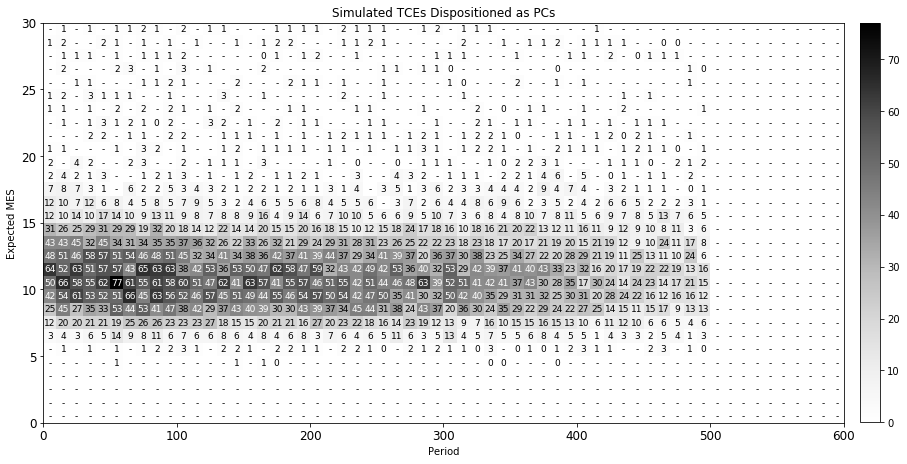

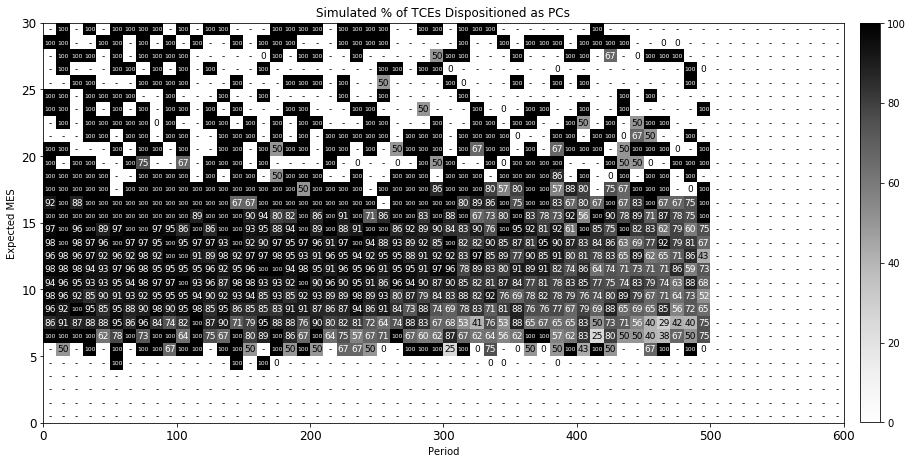

In [23]:
fitGrid = np.zeros(np.shape(tceGrid))

resultSize = np.shape(dataResult)
fitTheta = np.zeros(resultSize[0])
for i in range(resultSize[0]):
    fitTheta[i] = dataResult[i][0]
print("fitTheta = " + str(fitTheta))

for p in range(NPeriod):
    for m in range(NMes):
        fitGrid[(p,m)] = np.random.binomial(tceGrid[(p,m)], 
            funcModels.rateModel(cellX[(p,m)]+dx/2, cellY[(p,m)]+dy/2, fitTheta, model), 1)
        
drawHeatMap(fitGrid, (15,15), cellPeriod, cellMes, nData = tceGrid)
plt.title("Simulated TCEs Dispositioned as PCs")
plt.ylabel('Expected MES')
plt.xlabel('Period')

fitFrac = np.zeros(np.shape(tceGrid))
fitFrac[tceGrid>minTcePerCell] = fitGrid[tceGrid>minTcePerCell]/tceGrid[tceGrid>minTcePerCell]
drawHeatMap(np.round(100*fitFrac), (15,15), cellPeriod, cellMes, nData = tceGrid)
plt.title("Simulated % of TCEs Dispositioned as PCs")
plt.ylabel('Expected MES')
plt.xlabel('Period')
plt.show()

Now do many realizations, and subtract the average from the observed to look for systematic differences.

In [24]:
nFits = 100
fitGrid = np.zeros([np.shape(tceGrid)[0],np.shape(tceGrid)[1],nFits])
sidx = [0]*nFits
progress = FloatProgress(min=0, max=nFits)
display(progress)

for f in range(nFits):
    sidx[f] = int(np.random.uniform(high=samples.shape[0]-1))
    tTheta = samples[sidx[f],:]
    for p in range(NPeriod):
        for m in range(NMes):
            rm = funcModels.rateModel(cellX[(p,m)]+dx/2, cellY[(p,m)]+dy/2, tTheta, model)
            if rm > 1:
                rm = 1
            fitGrid[(p,m,f)] = np.random.binomial(tceGrid[(p,m)], rm, 1)
    progress.value += 1

meanFit = np.mean(fitGrid, 2)
stdFit = np.std(fitGrid, 2)

FloatProgress(value=0.0)

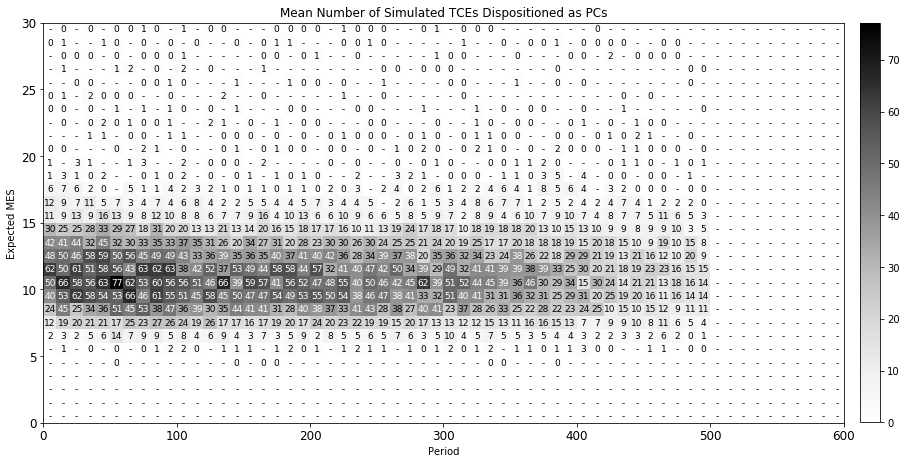

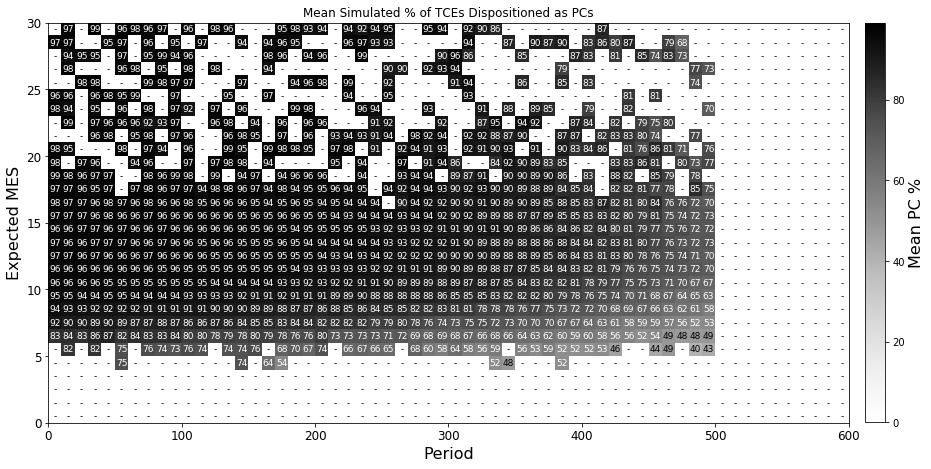

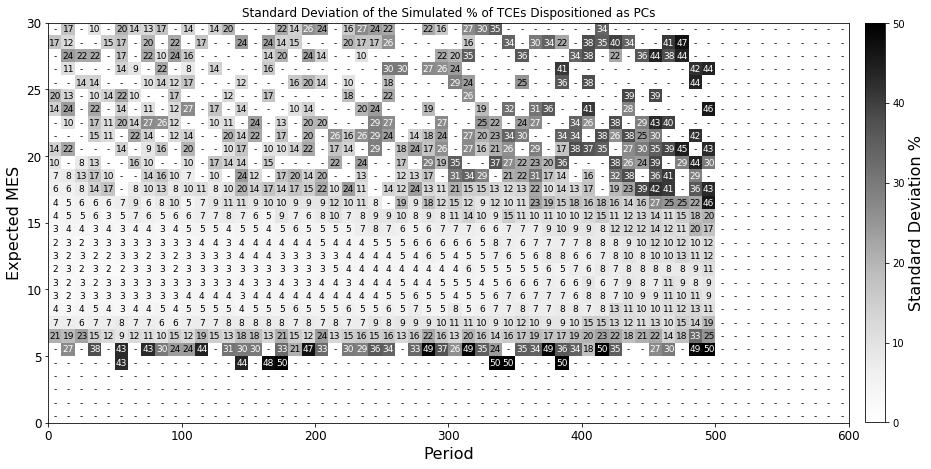

In [25]:
drawHeatMap(meanFit, (15,15), cellPeriod, cellMes, nData = tceGrid)
plt.title("Mean Number of Simulated TCEs Dispositioned as PCs")
plt.ylabel('Expected MES')
plt.xlabel('Period')

fitFracMean = np.zeros(np.shape(tceGrid))
fitFracMean[tceGrid>minTcePerCell] = meanFit[tceGrid>minTcePerCell]/tceGrid[tceGrid>minTcePerCell]
drawHeatMap(np.round(100*fitFracMean), (15,15), cellPeriod, cellMes, nData = tceGrid, colorBarLabel="Mean PC %")
plt.ylabel('Expected MES', fontsize = 16)
plt.xlabel('Period', fontsize = 16)
#plt.savefig("vetCompMean.pdf",bbox_inches='tight')
plt.title("Mean Simulated % of TCEs Dispositioned as PCs")

fitFracStd = np.zeros(np.shape(tceGrid))
fitFracStd[tceGrid>minTcePerCell] = stdFit[tceGrid>minTcePerCell]/tceGrid[tceGrid>minTcePerCell]
drawHeatMap(np.round(100*fitFracStd), (15,15), cellPeriod, cellMes, nData = tceGrid, colorBarLabel="Standard Deviation %") 
plt.ylabel('Expected MES', fontsize = 16)
plt.xlabel('Period', fontsize = 16)
#plt.savefig("vetCompStd.pdf",bbox_inches='tight')
plt.title("Standard Deviation of the Simulated % of TCEs Dispositioned as PCs")
plt.show()

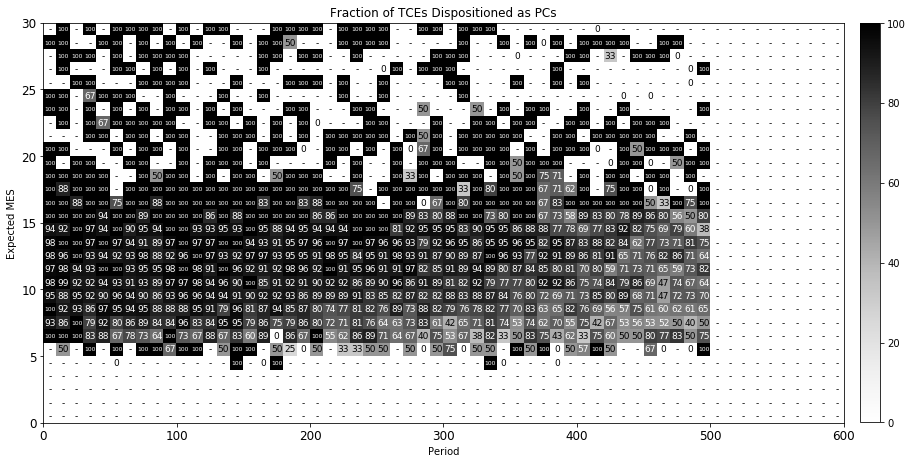

In [26]:
drawHeatMap(np.round(100*pcFrac), (15,15), cellPeriod, cellMes, nData = tceGrid)
plt.title("Fraction of TCEs Dispositioned as PCs")
plt.ylabel('Expected MES')
plt.xlabel('Period')
plt.show()

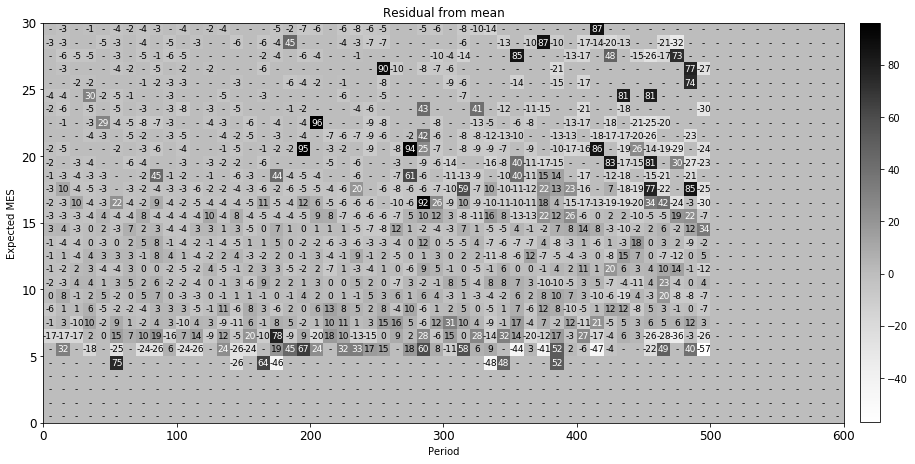

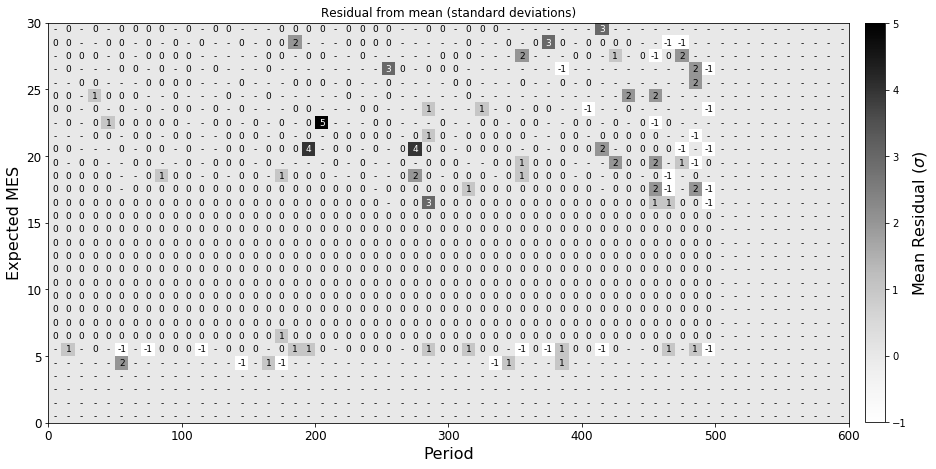

In [27]:
fitDiff = fitFracMean - pcFrac
fitDiffNorm = np.zeros(fitDiff.shape)
fitDiffNorm[tceGrid>minTcePerCell] = fitDiff[tceGrid>minTcePerCell]/stdFit[tceGrid>minTcePerCell]

drawHeatMap(np.round(100*fitDiff), (15,15), cellPeriod, cellMes, nData = tceGrid)
plt.title("Residual from mean")
plt.ylabel('Expected MES')
plt.xlabel('Period')

drawHeatMap(np.round(fitDiffNorm), (15,15), cellPeriod, cellMes, nData = tceGrid, 
            colorBarLabel="Mean Residual ($\sigma$)")
plt.ylabel('Expected MES', fontsize=16)
plt.xlabel('Period', fontsize=16)
plt.title("Residual from mean (standard deviations)")
#plt.savefig("vetCompMeanResid.pdf",bbox_inches='tight')
plt.show()

Plot the fitted functional form of the vetting efficiency.

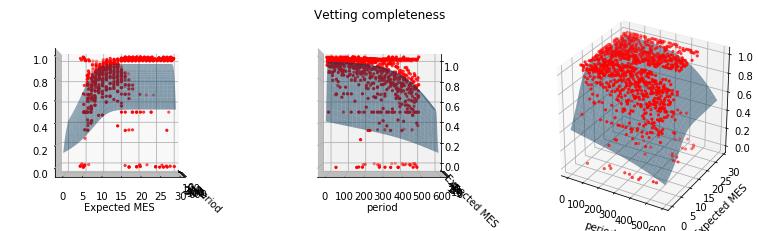

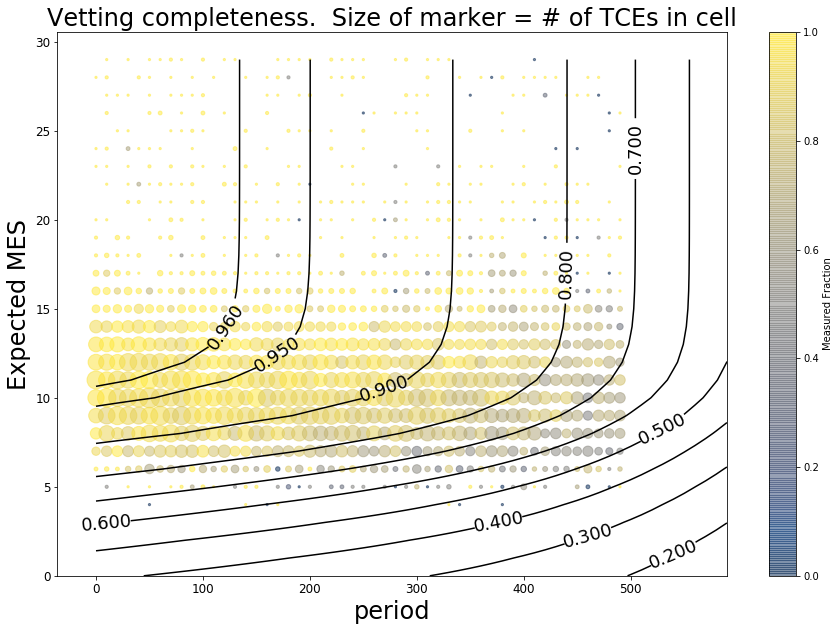

In [28]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

Z = funcModels.rateModel(cellX, cellY, fitTheta, model);

fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 3, 1, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5)
scat = ax.scatter(cellPeriod[tceGrid>0], cellMes[tceGrid>0], pcFrac[tceGrid>0], c='r', marker = '.')
plt.xlabel("period")
plt.ylabel("Expected MES")
ax.view_init(0,0)

ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5)
scat = ax.scatter(cellPeriod[tceGrid>0], cellMes[tceGrid>0], pcFrac[tceGrid>0], c='r', marker = '.')
plt.xlabel("period")
plt.ylabel("Expected MES")
ax.view_init(0,-90)
plt.title("Vetting completeness")

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax = fig.gca(projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5)
scat = ax.scatter(cellPeriod[tceGrid>0], cellMes[tceGrid>0], pcFrac[tceGrid>0], c='r', marker = '.')
plt.xlabel("period")
plt.ylabel("Expected MES")

fig, ax = plt.subplots(figsize=(15,10))
CS = ax.contour(cellPeriod, cellMes, Z, colors='k', 
                levels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .96, .97, .98, .99])
ax.clabel(CS, inline=1, fontsize=18)
scf = ax.scatter(cellPeriod[tceGrid>0], cellMes[tceGrid>0], cmap="cividis", 
                 c=pcFrac[tceGrid>0], s=5*tceGrid[tceGrid>0], alpha = 0.5)
plt.xlabel("period", fontSize = 24)
plt.ylabel("Expected MES", fontSize = 24)
cbh = plt.colorbar(scf)
cbh.ax.set_ylabel("Measured Fraction")
plt.tick_params(labelsize = 12)

plt.title("Vetting completeness.  Size of marker = # of TCEs in cell", fontSize = 24)
#plt.savefig("vetCompContours.pdf",bbox_inches='tight')
plt.show()

In [29]:
r1 = np.zeros(np.shape(samples)[0])
xp = 50.
yp = 25.
cx = (xp - periodMin)/(periodMax - periodMin)
cy = (yp - mesMin)/(mesMax - mesMin)
for i in range(np.shape(samples)[0]):
    r1[i] = funcModels.rateModel(cx, cy, samples[i,:], model)
f1 = funcModels.rateModel(cx, cy, fitTheta, model)
    
r2 = np.zeros(np.shape(samples)[0])
xp = 365.
yp = 10.
cx = (xp - periodMin)/(periodMax - periodMin)
cy = (yp - mesMin)/(mesMax - mesMin)
for i in range(np.shape(samples)[0]):
    r2[i] = funcModels.rateModel(cx, cy, samples[i,:], model)
f2 = funcModels.rateModel(cx, cy, fitTheta, model)

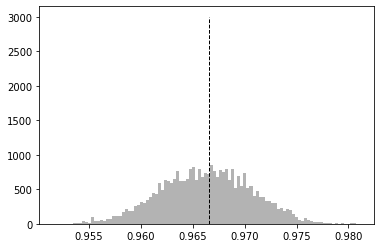

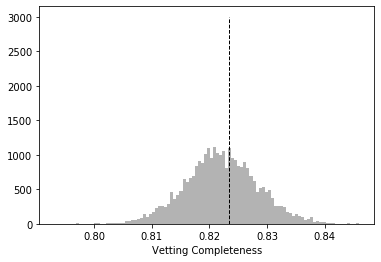

In [30]:
greyLevel = "0.7"
rr = np.percentile(r1, [5, 95])
plt.figure()
plt.hist(r1[(r1 > 0.95*rr[0]) & (r1 < 1.05*rr[1])], 100, color=greyLevel)
plt.plot([f1, f1], [0, 3000], color='k', linestyle='--', linewidth=1)

rr = np.percentile(r2, [5, 95])
plt.figure()
plt.hist(r2[(r2 > 0.95*rr[0]) & (r2 < 1.05*rr[1])], 100, color=greyLevel)
plt.plot([f2, f2], [0, 3000], color='k', linestyle='--', linewidth=1)

plt.xlabel("Vetting Completeness")
#plt.savefig("vetCompExamples.pdf",bbox_inches='tight')
plt.show()

In [31]:
np.percentile(r1, [16, 50, 84])

array([0.96188489, 0.96634039, 0.97064879])

In [32]:
np.percentile(r2, [16, 50, 84])

array([0.816008  , 0.82200439, 0.82824905])

In [33]:
l = np.zeros(np.shape(samples)[0])
aicDist = np.zeros(np.shape(samples)[0])
progress = FloatProgress(min=0, max=samples.shape[0])
display(progress)

for i in range(samples.shape[0]):
    l[i] = lnBinprob(samples[i,:], tceData, model)
    aicDist[i] = 2*len(samples[i,:]) - 2*lnBinlike(samples[i,:], tceData, model)
    progress.value += 1

FloatProgress(value=0.0, max=30000.0)

(array([1.500e+01, 9.800e+01, 1.800e+02, 3.480e+02, 5.200e+02, 7.520e+02,
        8.340e+02, 1.002e+03, 1.109e+03, 1.284e+03, 1.251e+03, 1.460e+03,
        1.374e+03, 1.328e+03, 1.244e+03, 1.358e+03, 1.213e+03, 1.219e+03,
        1.195e+03, 1.120e+03, 9.820e+02, 9.280e+02, 7.580e+02, 7.960e+02,
        8.590e+02, 6.280e+02, 6.050e+02, 6.150e+02, 6.300e+02, 4.790e+02,
        4.120e+02, 3.970e+02, 2.750e+02, 3.630e+02, 2.790e+02, 1.730e+02,
        2.140e+02, 2.370e+02, 1.390e+02, 2.000e+02, 1.340e+02, 1.290e+02,
        1.140e+02, 1.050e+02, 5.800e+01, 6.200e+01, 3.300e+01, 5.800e+01,
        3.800e+01, 4.800e+01, 3.600e+01, 4.100e+01, 3.900e+01, 3.500e+01,
        2.200e+01, 1.800e+01, 3.000e+01, 9.000e+00, 2.100e+01, 6.000e+00,
        1.900e+01, 7.000e+00, 8.000e+00, 7.000e+00, 6.000e+00, 7.000e+00,
        6.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 6.000e+00, 0.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+0

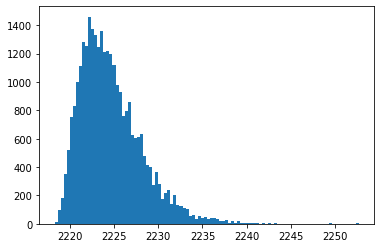

In [34]:
l[l<-1e8] = -1e8
aicDist[aicDist>1e8] = 1e8
minAic = np.min(aicDist)

plt.hist(aicDist[aicDist<1e8], 100)

In [35]:
aic = 2*len(fitTheta) - 2*(lnBinlike(fitTheta, tceData, model))

In [36]:
from skmonaco import mcquad

lbnds = np.empty([np.shape(samples)[1]])
ubnds = np.empty([np.shape(samples)[1]])
for i in range(len(lbnds)):
    lbnds[i] = np.min(samples[:,i])
    ubnds[i] = np.max(samples[:,i])

regularizationOffset = np.median(l)

def linBinProbInt(theta):
    return np.exp(lnBinprob(theta, tceData, model) - regularizationOffset)

BF, BFerror = mcquad(linBinProbInt, xl=lbnds,xu=ubnds, npoints=1e7,nprocs=8 )
#print("BF = {:.3e} +/- {:.3e}").format(BF,BFerror)

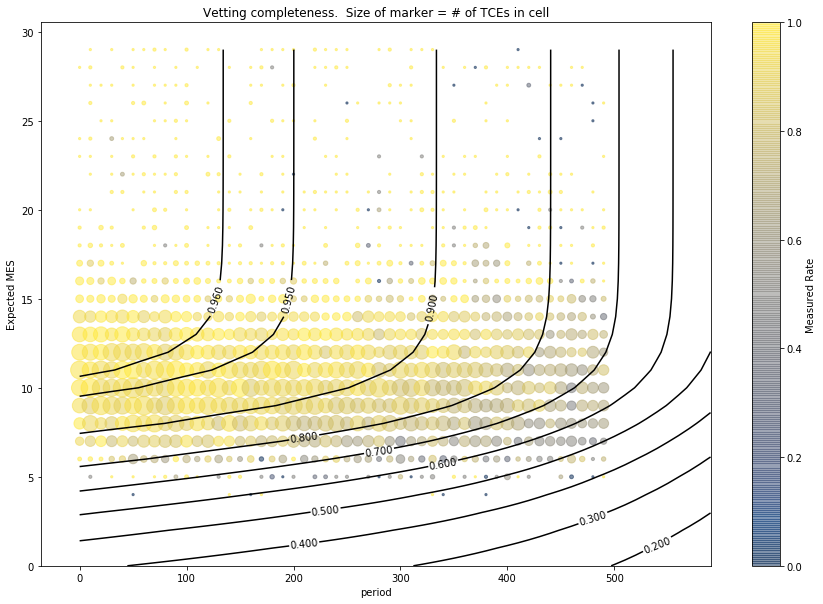

In [37]:
Z = funcModels.evaluateModel(cellPeriod, cellMes, fitTheta, [periodMin, periodMax], [mesMin, mesMax], model)

fig, ax = plt.subplots(figsize=(15,10))
CS = ax.contour(cellPeriod, cellMes, Z, colors='k', 
                levels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .96, .97, .98, .99])
ax.clabel(CS, inline=1, fontsize=10)
scf = ax.scatter(cellPeriod[tceGrid>0], cellMes[tceGrid>0], cmap="cividis", 
                 c=pcFrac[tceGrid>0], s=5*tceGrid[tceGrid>0], alpha = 0.5)
plt.xlabel("period")
plt.ylabel("Expected MES")
plt.title("Vetting completeness.  Size of marker = # of TCEs in cell")
cbh = plt.colorbar(scf)
cbh.ax.set_ylabel("Measured Rate")
plt.show()

In [38]:
import os.path
import pickle

fname = "vetCompletenessTable.pkl"
if os.path.isfile(fname):
    modelComparisonTable = pd.read_pickle(fname)
else:
    modelComparisonTable = pd.DataFrame({"Model": ["logisticY0", "dualBrokenPowerLaw",
                                                   "logisticX0xlogisticY0", "logisticX0xlogisticY02",
                                                   "logisticX0xRotatedLogisticY0", "logisticX0xRotatedLogisticY02",
                                                   "rotatedLogisticX0xlogisticY0", "rotatedLogisticX0xlogisticY02" ], 
                                        "medianMCMCAIC": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                        "minMCMCAIC": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                        "maxLikelihoodAIC": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                        "MedianLogPost": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                        "IntegralPost": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                        "IntegralPostErr": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                        "medianMCMCTheta": [[0],[0],[0],[0],[0],[0],[0],[0]],
                                        "maxLikelihoodTheta": [[0],[0],[0],[0],[0],[0],[0],[0]],
                                        "periodRange": [[0],[0],[0],[0],[0],[0],[0],[0]],
                                        "mesRange": [[0],[0],[0],[0],[0],[0],[0],[0]]},
                                       columns=["Model","BayesFactor","BayesFactorError","AICRelativeProb","medianMCMCAIC",
                                                "minMCMCAIC","maxLikelihoodAIC",
                                                "IntegralPost","IntegralPostErr","MedianLogPost","medianMCMCTheta",
                                                "maxLikelihoodTheta","periodRange","mesRange"])
    modelComparisonTable['IntegralPost'] = modelComparisonTable['IntegralPost'].map('{:,.3e}'.format)
    modelComparisonTable['IntegralPostErr'] = modelComparisonTable['IntegralPostErr'].map('{:,.3e}'.format)

In [39]:
# for this tutorial we are not doing model comparison, so only fill in data about this fit

In [40]:
mctIndex = np.where(modelComparisonTable["Model"].isin([model]))[0][0]
print(mctIndex)
modelComparisonTable["medianMCMCAIC"][mctIndex] = aic
modelComparisonTable["minMCMCAIC"][mctIndex] = minAic
#modelComparisonTable["maxLikelihoodAIC"][mctIndex] = maxLikelihoodAic
modelComparisonTable["MedianLogPost"][mctIndex] = regularizationOffset
modelComparisonTable["IntegralPost"][mctIndex] = BF
modelComparisonTable["IntegralPostErr"][mctIndex] = BFerror
modelComparisonTable["medianMCMCTheta"][mctIndex] = fitTheta
modelComparisonTable["maxLikelihoodTheta"][mctIndex] = maxLikelihoodResult
modelComparisonTable["periodRange"][mctIndex] = [periodMin, periodMax]
modelComparisonTable["mesRange"][mctIndex] = [mesMin, mesMax]

5


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.htm

We also compute the relative probability from the $\mathrm{AIC} = 2k - 2 \log(\mathrm{likelihood})$, where $k$ is the number of parameters in the model and the relative probability is $\exp\left(\left(\mathrm{AIC}_\mathrm{min} - \mathrm{AIC}\right)/2\right)$.

In [41]:
modelToCompareIndex = 4
modelComparisonTable["AICRelativeProb"] = 0.
minAic = np.min(modelComparisonTable["medianMCMCAIC"][modelToCompareIndex])

for i in range(len(modelComparisonTable)):
    modelComparisonTable["AICRelativeProb"].iloc[i] = np.exp((minAic - modelComparisonTable["medianMCMCAIC"].iloc[i])/2.)

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [42]:
modelComparisonTable["BayesFactor"] = 0.
c1 = modelComparisonTable["MedianLogPost"].iloc[modelToCompareIndex]
i1 = np.double(modelComparisonTable["IntegralPost"].iloc[modelToCompareIndex])
for i in range(len(modelComparisonTable)):
    c2 = modelComparisonTable["MedianLogPost"].iloc[i]
    modelComparisonTable["BayesFactor"].iloc[i] = np.exp(c2 - c1)*np.double(modelComparisonTable["IntegralPost"].iloc[i])/i1

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Because the terms in the Bayes factor are computed via Monte Carlo integration with a non-trivial error, we propagate that error through to an error on the Bayes factor.

In [43]:
B = np.double(modelComparisonTable["IntegralPost"].iloc[modelToCompareIndex])
sB = np.double(modelComparisonTable["IntegralPostErr"].iloc[modelToCompareIndex])
c1 = modelComparisonTable["MedianLogPost"].iloc[modelToCompareIndex]
for i in range(len(modelComparisonTable)):
    c2 = modelComparisonTable["MedianLogPost"].iloc[i]
    f = np.double(modelComparisonTable["BayesFactor"].iloc[i])
    A = np.exp(c2 - c1)*np.double(modelComparisonTable["IntegralPost"].iloc[i])
    sA = np.exp(c2 - c1)*np.double(modelComparisonTable["IntegralPostErr"].iloc[i])
    modelComparisonTable["BayesFactorError"].iloc[i] = f*np.sqrt((sA/A)**2 + (sB/B)**2)

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [44]:
modelComparisonTable

,Model,BayesFactor,BayesFactorError,AICRelativeProb,medianMCMCAIC,minMCMCAIC,maxLikelihoodAIC,IntegralPost,IntegralPostErr,MedianLogPost,medianMCMCTheta,maxLikelihoodTheta,periodRange,mesRange
0,logisticY0,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
1,dualBrokenPowerLaw,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
2,logisticX0xlogisticY0,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
3,logisticX0xlogisticY02,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
4,logisticX0xRotatedLogisticY0,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
5,logisticX0xRotatedLogisticY02,NaN,NaN,0.0,2218.293005,2218.254902,0.0,0.000e+00,0.000e+00,-1104.007036,"[1.0109993769877694, 0.28121840119283387, 5.54...","[1.0139101686382985, 0.2643650052400061, 5.439...","[0, 600]","[0, 30]"
6,rotatedLogisticX0xlogisticY0,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
7,rotatedLogisticX0xlogisticY02,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]


In [45]:
modelComparisonTable.to_pickle(fname)

In [46]:
tt = pd.read_pickle(fname)

In [47]:
tt

,Model,BayesFactor,BayesFactorError,AICRelativeProb,medianMCMCAIC,minMCMCAIC,maxLikelihoodAIC,IntegralPost,IntegralPostErr,MedianLogPost,medianMCMCTheta,maxLikelihoodTheta,periodRange,mesRange
0,logisticY0,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
1,dualBrokenPowerLaw,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
2,logisticX0xlogisticY0,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
3,logisticX0xlogisticY02,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
4,logisticX0xRotatedLogisticY0,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
5,logisticX0xRotatedLogisticY02,NaN,NaN,0.0,2218.293005,2218.254902,0.0,0.000e+00,0.000e+00,-1104.007036,"[1.0109993769877694, 0.28121840119283387, 5.54...","[1.0139101686382985, 0.2643650052400061, 5.439...","[0, 600]","[0, 30]"
6,rotatedLogisticX0xlogisticY0,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
7,rotatedLogisticX0xlogisticY02,NaN,NaN,1.0,0.000000,0.000000,0.0,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]


%%javascript
IPython.notebook.save_notebook()

%%bash -s "$model"
jupyter nbconvert --to html binomialVettingCompleteness.ipynb
mv binomialVettingCompleteness.html htmlArchive/binomialVettingCompleteness_$1.html

In [48]:
import os
os.system("echo 'hello world'")
os.system("say 'hello world'")

0